In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [2]:
"""     ====>     initial parameters     <====     """
'''QDS'''
n = 24   #number of QDs [no unit]
R = 5.36290830288e-07   #radius of QD setup [m]
diam = 20e-9    #diameter of QD (atm made up)[m]
ts = 30e-9 #double quoted 15ns, time spent stopped between steps, time needed to discharge and charge quantum dot [s]
'''Permanent Charges'''
p = 12   #number of permanent charges (PCs) [no unit]
Rp = 5.36290830288e-07 - 110e-9   #radius of rotating disc [m]
r = Rp/3    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
ro = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
cd = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
'''Other constants'''
eps = 8.854e-12 #currently set to epsilon 0 [F/m]
k = 1/(4*math.pi*eps)
e = 1.60217662e-19 # [C]
r0 = R - Rp   #distance between roatating disc and centre of QD setup above [m]
fluid_density = 0.164 #helium
kinematic_viscosity = 3.12e-5/fluid_density #helium absolute viscosity/density
eta = kinematic_viscosity * fluid_density    #shear viscosity = kinematic viscosity * denisty of fluid
beta = 0 #bulk viscoisty

In [3]:
def intertia( ro, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * ro * math.pi * thc * ( Rp ** 4 )
    return I

In [4]:
def permanent_charge_magnitude( Rp, p , cd, vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (3*math.pi*(Rp**2))/(4*p) #see notebook for deriviation (not correct for capacitor arms)
    capacitance = cd * segment_area #capacitance of one segment
    stored_charge = capacitance * vol #stored charge in one segment
    return stored_charge

In [5]:
def permanent_charges( Rp, p , cd, vol):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( Rp, p , cd, vol)
        else:
            p_ch = -permanent_charge_magnitude( Rp, p , cd, vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

In [6]:
def quantum_dots( n, e):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, 24, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = 2*e
        elif i in range(3,24,4):
            q_ch = -2*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [7]:
def tangential_component(n, e, R, r0, gamma):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n,e) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge
        F_c = k*PCs[0][3]*Q[3]/(ri**2) #coulomb force between permanent charge and QD
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        if (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) > 1 or (((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos(((r0**2)+(ri**2)-(d**2))/(2*r0*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha
        F_t += F_c*math.sin(alpha) #???
    return F_t

In [8]:
def torque (F_t, Rp, p):
    """Computes torque on enitre inner rotor"""
    torque = F_t * Rp * p
    return torque

In [9]:
def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

In [10]:
def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

In [11]:
def Charging_energy( q, e, Cdot):
    energy = (q*(e**2)/(2*Cdot))
    return energy

In [12]:
def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

In [13]:
def Charging_time( Rt, Cdot):
    tc = Rt * Cdot
    return tc

In [14]:
def Input_power():
    return p_in

1.4426992150961694e-08
3.462478116230807e-07
2888104.8960638125


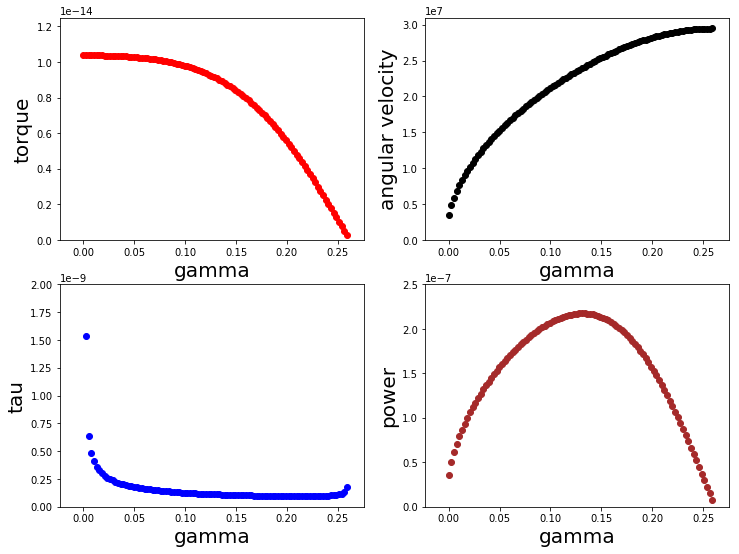

In [15]:
"""Main function"""
time = 0
step = math.pi*(360/24)/180 #angle between each QD, angle required for one step
angle_increment = step/100
PCs = permanent_charges( Rp, p , cd, vol) #initializes permanent charges

"""Graphs of output results of interest"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_xlabel('gamma', fontsize = '20')
ax1.set_ylabel('torque', fontsize = '20')
ax1.set_ylim( 0 , 1.25e-14)
ax2.set_xlabel('gamma', fontsize = '20')
ax2.set_ylabel('angular velocity', fontsize = '20')
ax2.set_ylim(0, 0.31e8)
ax3.set_xlabel('gamma', fontsize = '20')
ax3.set_ylabel('tau', fontsize = '20')
ax3.set_ylim(0, 0.2e-8)
ax4.set_xlabel('gamma', fontsize = '20')
ax4.set_ylabel('power', fontsize = '20')
ax4.set_ylim(0, 0.25e-6)

"""Computation"""
v_ang = [] #angular velocity
v_a = 0
v_ang.append( 0 ) #starting angluar velocity is 0
i = 0
T = []
gamma_list = []
I = intertia( ro, thc, Rp)
for gamma in np.arange(0, step, angle_increment): #iterates angle increment until one step is completed
    #F_t = tangential_component(n, e, R, r0, gamma) - viscous_force(n, eta, beta, Rp, r, v_ang, angle_increment, thc, i) #resultant tangential force
    gamma_list.append( gamma )
    F_t = tangential_component(n, e, R, r0, gamma)
    T.append( torque(F_t, Rp, p) ) #calculates torque acting on inner rotor
    #print ( "torque=" , T )
    ax1.scatter(gamma, T[i] , color = 'r') #plots torque vs angle rotated
    v_a = angular_velocity(angle_increment, v_ang, i, T[i], I) #calculates angular velocity after rotating by angle increment
    #print ( "v_ang=" , v_a )
    v_ang.append( v_a )
    ax2.scatter(gamma, v_a, color = 'k') #plots angular velocity vs angle rotated
    tau = time_step( I, T[i], v_ang ) #calculates time taken to rotate angle
    ax3.scatter(gamma, tau, color = 'b') #plots time taken vs angle rotated
    ax4.scatter(gamma, (v_a * T[i]), color = 'brown') #plots power vs angle rotated
    time += tau #total time taken
    i += 1 #needed to keep track of arrays; v_ang, T
print (time)
print (time * n)
print ( 1/(time * n) )
plt.show()

In [23]:
def func(x, A, C):
    return A * (x**2) + C 

In [24]:
for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e14

popt, pcov = curve_fit(func, gamma_list, T)

for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e-14

-1.45505776765e-13 1.10214833407e-14


C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


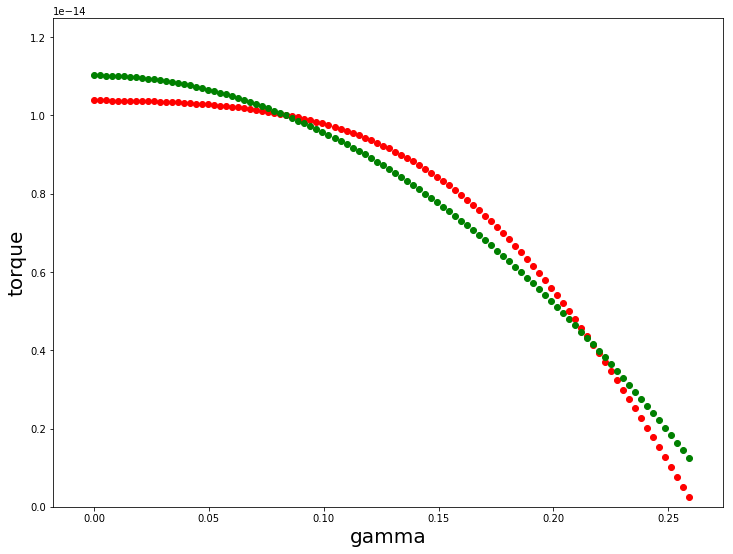

In [25]:
A = popt[0] * 1e-14
C = popt[1] * 1e-14

print (A, C)
fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx2 = fig2.add_subplot(111)
bx1.set_xlabel('gamma', fontsize = '20')
bx1.set_ylabel('torque', fontsize = '20')
bx1.set_ylim( 0 , 1.25e-14)
for i in np.arange( 0, int(step/angle_increment) ):
    bx1.scatter( gamma_list[i], T[i], color = 'r' )
    bx2.scatter( gamma_list[i], ( func(gamma_list[i], A, C) ), color= 'g' )
plt.show()

In [39]:
def solvr( Y, t, params):
    const, A, C = params
    return [ Y[1], (A*(Y[0]**2) - const*Y[1] + C) ]

In [43]:
print (math.log( Rp/(Rp-r)) )
constant = n/2 * ( 8*eta/3 * ( math.log( Rp/(Rp-r) ) ) + beta*r*thc ) #coefficient of drag force function
print (constant)
params = [ (constant* (Rp/2))/I , A/I, C/I ]
print ( params )
tStop = 0.04
tInc = 1e-4
t_array = np.arange( 0, tStop, tInc)
sol = odeint( solvr, [0,0], t_array, args=(params,) )

0.40546510810816455
0.00040481636393519145
[1.848194633891568e+19, -31166919965036844.0, 2360770113821723.5]


In [41]:
print (sol)

[[  0.00000000e+00   0.00000000e+00]
 [  1.27733847e-08   1.27733847e-04]
 [  2.55467695e-08   1.27733847e-04]
 [  3.83201542e-08   1.27733847e-04]
 [  5.10935390e-08   1.27733847e-04]
 [  6.38669237e-08   1.27733847e-04]
 [  7.66403085e-08   1.27733847e-04]
 [  8.94136932e-08   1.27733847e-04]
 [  1.02187078e-07   1.27733847e-04]
 [  1.14960463e-07   1.27733847e-04]
 [  1.27733847e-07   1.27733847e-04]
 [  1.40507232e-07   1.27733847e-04]
 [  1.53280617e-07   1.27733847e-04]
 [  1.66054002e-07   1.27733847e-04]
 [  1.78827386e-07   1.27733847e-04]
 [  1.91600771e-07   1.27733847e-04]
 [  2.04374156e-07   1.27733847e-04]
 [  2.17147541e-07   1.27733847e-04]
 [  2.29920925e-07   1.27733847e-04]
 [  2.42694310e-07   1.27733847e-04]
 [  2.55467695e-07   1.27733847e-04]
 [  2.68241080e-07   1.27733847e-04]
 [  2.81014464e-07   1.27733847e-04]
 [  2.93787849e-07   1.27733847e-04]
 [  3.06561234e-07   1.27733847e-04]
 [  3.19334619e-07   1.27733847e-04]
 [  3.32108003e-07   1.27733847e-04]
 

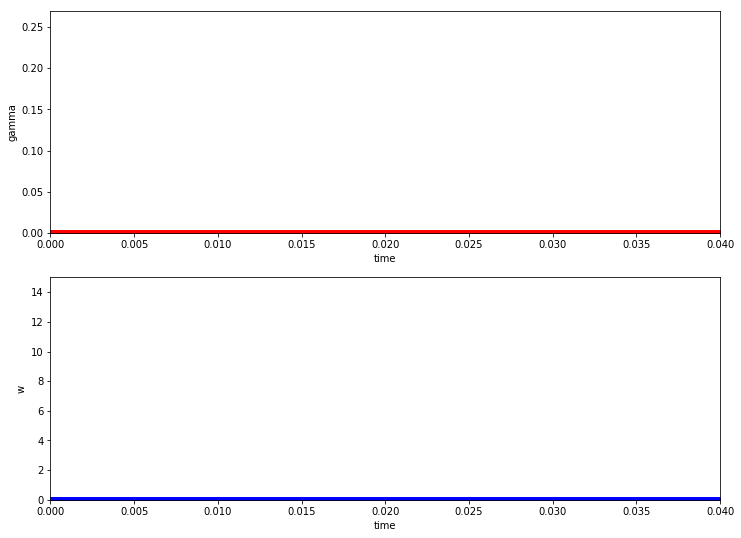

In [42]:
# Plot results: gamma as function of t
fig3 = plt.figure(figsize=(12, 9))
cx1 = fig3.add_subplot(211)
cx1.set_xlabel('time')
cx1.set_ylabel('gamma')
cx1.set_ylim( 0 , 0.27 )
cx1.set_xlim( 0 , tStop )
cx2 = fig3.add_subplot(212)
cx2.set_xlabel('time')
cx2.set_ylabel('w')
cx2.set_ylim( 0 , 15 )
cx2.set_xlim( 0 , tStop )
for i in np.arange( 0, len(t_array) ):
    cx1.scatter( t_array[i], sol[i][0], color='r' )
    cx2.scatter( t_array[i], sol[i][1], color='b' )
plt.show()

In [117]:
for i in np.arange( 0, len(t_array) ):
    if sol[i][0] >= step:
        step_time = t_array[i]
        break
print (step_time)
print (step_time * n)
print ( 1/(step_time * n) )

0.0385
0.924
1.08225108225


In [ ]:
accel = []
for i in np.arange( 1, len(t_array) ):
    accel.append( (sol[i][1] - sol[i-1][1])/tInc )
print (accel)

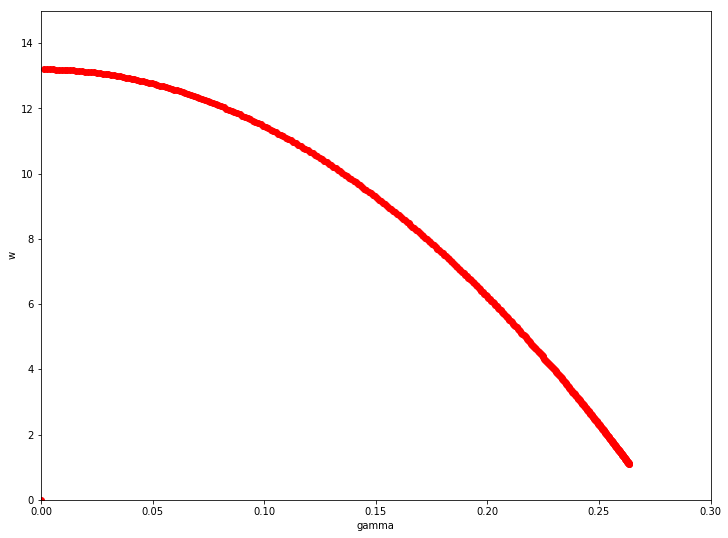

In [113]:
fig4 = plt.figure(figsize=(12, 9))
dx1 = fig4.add_subplot(111)
dx1.set_xlabel('gamma')
dx1.set_ylabel('w')
dx1.set_ylim( 0 , 15 )
dx1.set_xlim( 0 , 0.3)
for i in np.arange( 0, len(t_array) ):
    dx1.scatter( sol[i][0], sol[i][1], color='r' )
plt.show()def flagella( Y, t, params):
    const, F = params
    return [ Y[1], F - const*Y[1] ]

In [ ]:
def flagella( Y, t, params):
    const, F = params
    return [ Y[1], F - const*Y[1] ]

In [ ]:
params = [ constant/I, 4500e-21]